## Code for inference using my Model's API

### Imports

In [12]:
import requests
import cv2
import matplotlib.pyplot as plt
import json
from PIL import Image
import io

### Process Prediction Functions

In [16]:
def process_prediction_results(json_response):
    try:
        # Parse the nested JSON string in the results field
        results = json.loads(json_response['results'])
        return results
    except Exception as e:
        print(f"Error processing results: {e}")
        return None

In [17]:
def draw_predictions(image, predictions):
    img_copy = image.copy()

    for pred in predictions:
        name = pred['name']
        conf = pred['confidence']
        box = pred['box']

        x1, y1 = int(box['x1']), int(box['y1'])
        x2, y2 = int(box['x2']), int(box['y2'])

        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = f"{name}: {conf:.2%}"
        cv2.putText(img_copy, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img_copy

In [22]:
def predict_plant(image_path, api_url="https://coralengel-plant-recognition-api.hf.space/predict"):
    # Read and resize the image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (300, 300))

    # Convert to RGB (PIL format)
    image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # Convert to bytes
    img_byte_arr = io.BytesIO()
    pil_image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    # Prepare the files for the request
    files = {
        'file': ('image.jpg', img_byte_arr, 'image/jpeg')
    }

    try:
        # Make the POST request to the API
        response = requests.post(api_url, files=files)
        response.raise_for_status()

        # Process results
        predictions = process_prediction_results(response.json())
        if predictions:

            print("\nPrediction:")
            for pred in predictions:
                print(f"- {pred['name']} (Confidence: {pred['confidence']:.2%})")

            result_image = draw_predictions(image_rgb, predictions)

            plt.figure(figsize=(8, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(result_image)
            plt.title("Predictions")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return predictions
    except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
        return None

### Download images

In [13]:
!wget https://horizonvets.com/wp-content/uploads/2024/02/aloe-vera-white-pot_sunwand24-ss_edit_0.jpg -O aloe_vera.jpg
!wget https://houseplanthouse.com/wp-content/uploads/2020/07/nanouk-e1594225952235.jpg -O tradescantia.jpg

--2025-02-07 23:01:57--  https://horizonvets.com/wp-content/uploads/2024/02/aloe-vera-white-pot_sunwand24-ss_edit_0.jpg
Resolving horizonvets.com (horizonvets.com)... 104.21.80.1, 104.21.64.1, 104.21.16.1, ...
Connecting to horizonvets.com (horizonvets.com)|104.21.80.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86144 (84K) [image/jpeg]
Saving to: ‘aloe_vera.jpg’

aloe_vera.jpg       100%[===================>]  84.12K  --.-KB/s    in 0.01s   

2025-02-07 23:01:57 (6.03 MB/s) - ‘aloe_vera.jpg’ saved [86144/86144]

--2025-02-07 23:01:57--  https://houseplanthouse.com/wp-content/uploads/2020/07/nanouk-e1594225952235.jpg
Resolving houseplanthouse.com (houseplanthouse.com)... 192.0.78.25, 192.0.78.24
Connecting to houseplanthouse.com (houseplanthouse.com)|192.0.78.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1509047 (1.4M) [image/jpeg]
Saving to: ‘tradescantia.jpg’

tradescantia.jpg    100%[===================>]   1.44M  --.-KB/s

In [14]:
# Test with each image
image_paths = ['aloe_vera.jpg', 'tradescantia.jpg']

### Run predictions


Processing aloe_vera.jpg:

Prediction:
- Aloe Vera (Confidence: 97.47%)


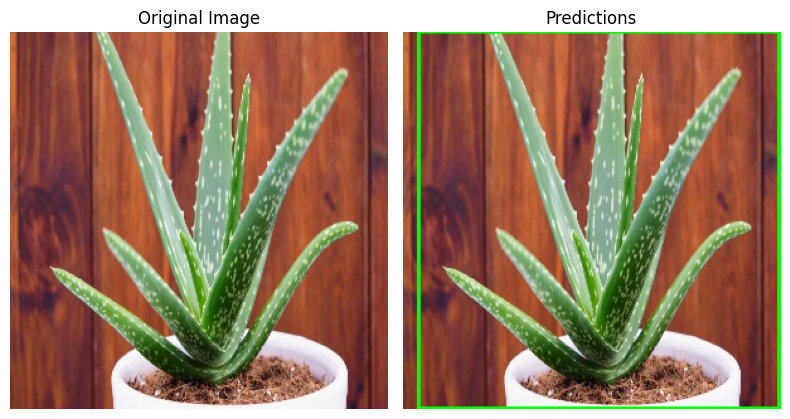


Processing tradescantia.jpg:

Prediction:
- Tradescantia (Confidence: 77.23%)


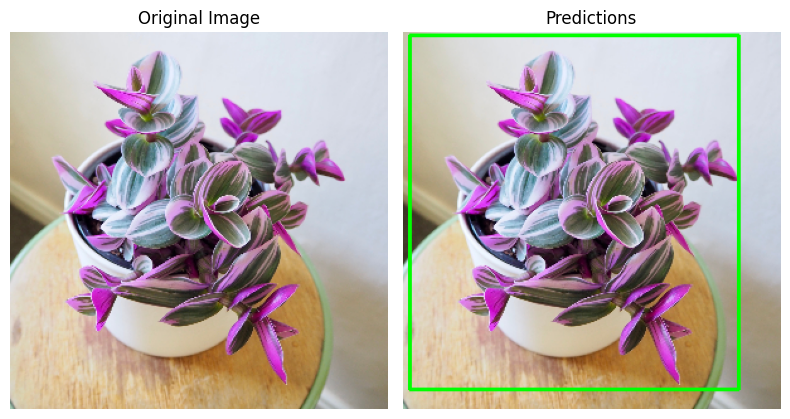

In [23]:
for image_path in image_paths:
    print(f"\nProcessing {image_path}:")
    results = predict_plant(image_path)